<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/jedi/disaster_tweets_jedi_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [3]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer()
#bow_cv = cv.fit_transform(df["_lemmatized"])

## definitions 

In [4]:
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# get data

[Daten](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [5]:
disaster_tweets = pd.read_csv('/content/drive/My Drive/disaster_tweets.csv', encoding='latin-1')

In [6]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


# Frage an Petra: wieso 50%  --- ich hab 43% ?

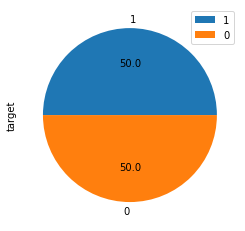

In [7]:
disaster_tweets.loc[[1, 0], :].plot.pie(y='target', autopct=lambda x: round(x, 2));

In [8]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )

In [9]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)


keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [10]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [11]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

In [12]:
### we might do these steps later after having processed the text :)
#dt = disaster_tweets.copy()

# jedi

In [13]:
dt = my_df_text_mining(disaster_tweets.copy(), 'text')
dt

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident asked 'shelter place' notified office...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane holding bridge collapse nearby...,1
7609,10870,NaN,NaN,aria ahrary thetawniest control wild fire cali...,1
7610,10871,NaN,NaN,utc km volcano hawaii http co zdtoyd ebj,1
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1


# kann doch weg :)

In [14]:
no_keyword_ = dt[  dt.keyword.isna()]
keyword_    = dt[ ~dt.keyword.isna()]

In [15]:
keyword_.groupby('keyword').target.count()

keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: target, Length: 221, dtype: int64

In [16]:
no_location_ = dt[  dt.location.isna()]
location_    = dt[ ~dt.location.isna()]

In [17]:
no_target_ = dt[ dt.target == 0]
target_    = dt[ dt.target == 1]

In [18]:
location_

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesale market ablaze http co lhyxeohy c,1
32,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt http co yao e ...,0
33,50,ablaze,AFRICA,africanbaze breaking news nigeria flag set abl...,1
34,52,ablaze,"Philadelphia, PA",cry set ablaze,0
35,53,ablaze,"London, UK",plus side look sky last night ablaze http co q...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,bright side wrecked http co uea txrhys,0
7577,10829,wrecked,#NewcastleuponTyne #UK,widda he's gone relax thought wife wrecked cak...,0
7579,10831,wrecked,"Vancouver, Canada",three day work they've pretty much wrecked hah...,0
7580,10832,wrecked,London,fx forex trading cramer iger's word wrecked di...,0


# bis hier :)

In [33]:
df= dt
#no_df = location_

In [20]:
#tfidf_v = TfidfVectorizer(ngram_range=(1, 2))
#tfidf_bow = tfidf_v.fit_transform(df["_lemmatized"])   # FIT and transform to learn
### ??? wo wird das denn weiterverwendet ???

In [21]:
#tfidf_v.transform(no_df['_lemmatized'])  # only transformation!!!

In [22]:
X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])

0.7949096880131362

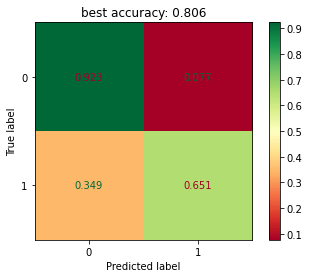

In [23]:
#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

0.7888341543513958

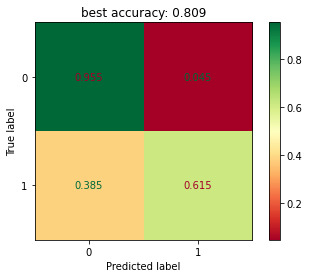

In [34]:

df=disaster_tweets

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])


#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()